### Modules

In [1]:
import os, glob, random
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import albumentations as A

from google.colab import drive

### Global Variables

In [2]:
NUM_CLASSES = 8
NUM_EPOCHS = 100
IMAGE_WIDTH, IMAGE_HEIGHT = 240, 240
CLASSES = ['NONE', 'Audi S6', 'BMW X5', 'Chrysler Pacifica', 'Hyundai ix35', 'Mazda 6', 'Renault Megane', 'Toyota Corolla']

TRAIN_FOLDER = '/content/gdrive/MyDrive/Colab Notebooks/tasarım/dataset/train'
VALID_FOLDER = '/content/gdrive/MyDrive/Colab Notebooks/tasarım/dataset/valid'
TEST_FOLDER = '/content/gdrive/MyDrive/Colab Notebooks/tasarım/dataset/test'

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


### Mount

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Dataset Class

In [4]:
class TireDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transforms):
        self.image_paths = image_paths
        self.transforms = transforms

    def __getitem__(self, idx):
        filepath = self.image_paths[idx]

        image = Image.open(filepath)
        mask = Image.open(filepath.replace('.jpg', '.png'))

        augmented = self.transforms(image=np.array(image), mask=np.array(mask))
        t_image, t_mask = augmented['image'], augmented['mask']
        t_image, t_mask = torch.from_numpy(t_image), torch.from_numpy(t_mask)

        t_image = 1.0 - (t_image / 255.0)
        t_image = t_image.unsqueeze(0)

        t_mask = t_mask.to(torch.long)
        
        return t_image, t_mask

    def __len__(self):
        return len(self.image_paths)

In [ ]:
train_aug = A.Compose([
    A.RandomCrop(height=480, width=480, p=0.5),
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
])

valid_aug = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
])

In [ ]:
train_files = glob.glob(f'{TRAIN_FOLDER}/*/*.jpg')
train_set = TireDataset(train_files, transforms=train_aug)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

valid_files = glob.glob(f'{VALID_FOLDER}/*/*.jpg')
valid_set = TireDataset(valid_files, transforms=valid_aug)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

### Architecture

In [5]:
class DoubleConv(torch.nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.conv = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)

In [6]:
class UNET(torch.nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
    super().__init__()
    self.ups = torch.nn.ModuleList()
    self.downs = torch.nn.ModuleList()
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(torch.nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
      self.ups.append(DoubleConv(feature * 2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
    self.final_conv = torch.nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []
    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)

    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx + 1](concat_skip)

    return torch.softmax(self.final_conv(x), axis=1)

### Train stage

In [ ]:
def train_fn(loader, model, optimizer, loss_fn):
  total_loss = 0.0
  model.train()

  for batch_idx, (x, y) in enumerate(loader):
    x, y = x.to(DEVICE), y.to(DEVICE)

    pred_y = model(x)
    loss = loss_fn(pred_y, y)
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return (total_loss / len(loader))

In [ ]:
def valid_fn(loader, model, loss_fn):
  total_loss = 0.0
  model.eval()

  with torch.no_grad(): 
    for batch_idx, (x, y) in enumerate(loader):
      x, y = x.to(DEVICE), y.to(DEVICE)

      pred_y = model(x)
      total_loss += loss_fn(pred_y, y).item()
    
    return (total_loss / len(loader))

In [ ]:
model = UNET(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train_y, valid_y = [], []
min_loss = 100.0

for i in range(NUM_EPOCHS):
  loss = train_fn(train_loader, model, optimizer, loss_fn)
  train_y.append(loss)

  vloss = valid_fn(valid_loader, model, loss_fn)
  valid_y.append(vloss)
  
  print('{0}.loss: {1:.4f}    vloss: {2:.4f}'.format(i + 1, loss, vloss))

  if (vloss < min_loss):
    min_loss = vloss
    torch.save(model.state_dict(), 'model.data')

1.loss: 1.9527    vloss: 1.9962
2.loss: 1.7747    vloss: 1.7101
3.loss: 1.6070    vloss: 1.6178
4.loss: 1.4782    vloss: 1.4345
5.loss: 1.4096    vloss: 1.4003
6.loss: 1.3734    vloss: 1.3601
7.loss: 1.3595    vloss: 1.3426
8.loss: 1.3530    vloss: 1.3633
9.loss: 1.3454    vloss: 1.3488
10.loss: 1.3407    vloss: 1.3302
11.loss: 1.3367    vloss: 1.3541
12.loss: 1.3331    vloss: 1.3219
13.loss: 1.3302    vloss: 1.3213
14.loss: 1.3296    vloss: 1.4214
15.loss: 1.3295    vloss: 1.3428
16.loss: 1.3247    vloss: 1.3390
17.loss: 1.3270    vloss: 1.3379
18.loss: 1.3186    vloss: 1.3040
19.loss: 1.3171    vloss: 1.3374
20.loss: 1.3138    vloss: 1.3451
21.loss: 1.3128    vloss: 1.3210
22.loss: 1.3077    vloss: 1.3372
23.loss: 1.3074    vloss: 1.3205
24.loss: 1.3041    vloss: 1.3057
25.loss: 1.2975    vloss: 1.3180
26.loss: 1.2961    vloss: 1.3021
27.loss: 1.2984    vloss: 1.2893
28.loss: 1.2992    vloss: 1.2994
29.loss: 1.2967    vloss: 1.2942
30.loss: 1.2930    vloss: 1.2966
31.loss: 1.2938    

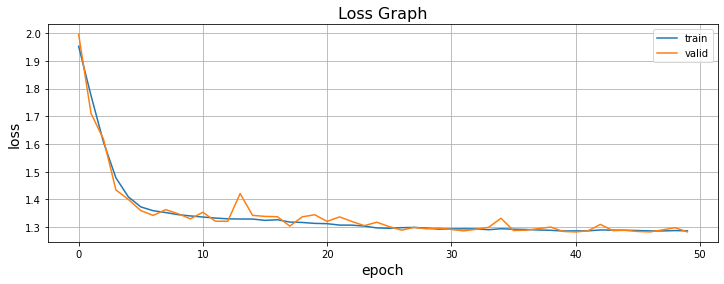

In [ ]:
plt.rcParams["figure.figsize"] = (12, 4)

plt.title('Loss Graph', fontsize=16)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)

plt.plot(train_y)
plt.plot(valid_y)
plt.legend(['train', 'valid'])
plt.grid()

plt.show()

### Test stage

In [7]:
WEIGHT_PATH = '/content/gdrive/MyDrive/Colab Notebooks/tasarım/weights/model.data'
PALETTE = np.array([[148, 103, 189],
                    [31,  119, 180],
                    [255, 127,  14],
                    [ 44, 160,  44],
                    [214,  39,  40],
                    [236, 119, 194],
                    [188, 189,  34],
                    [ 23, 190, 207]])

In [8]:
model = UNET(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(WEIGHT_PATH, map_location=DEVICE))

<All keys matched successfully>

In [31]:
test_aug = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
])

test_files = glob.glob(f'{TEST_FOLDER}/*/*.jpg')
test_set = TireDataset(test_files, transforms=test_aug)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
test_iter = iter(test_loader)

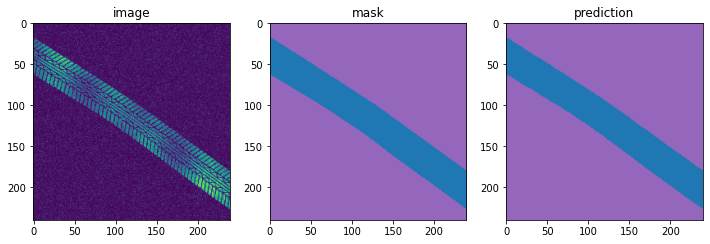

In [33]:
images, masks = next(test_iter)
images, masks = images.to(DEVICE), masks.to(DEVICE)

model.eval()
with torch.no_grad():
  output = model(images)
model.train()

predictions = output.argmax(1)

images = images.cpu().detach().numpy()
masks = masks.cpu().detach().numpy()
preds = predictions.cpu().detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].set_title('image')
ax[0].imshow(images[0, 0])

ax[1].set_title('mask')
ax[1].imshow(PALETTE[masks[0]])

ax[2].set_title('prediction')
ax[2].imshow(PALETTE[preds[0]])

plt.show()

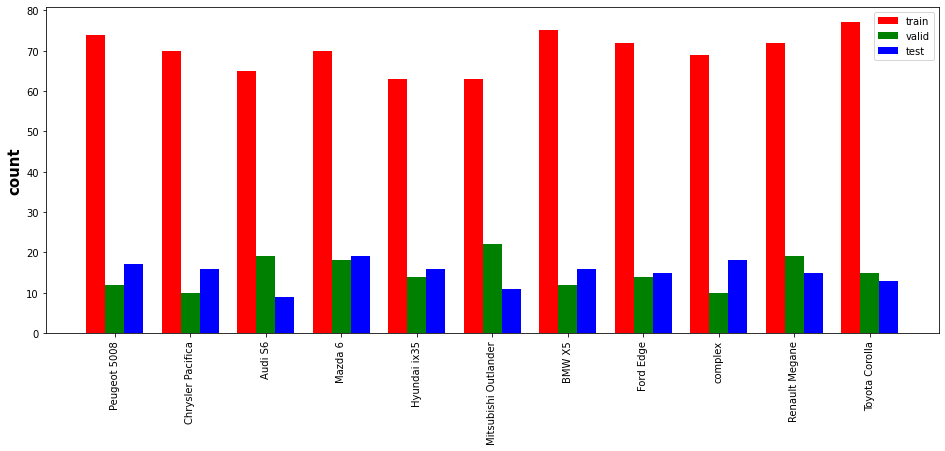

In [11]:
train_dist = {dir: len(glob.glob(f'{TRAIN_FOLDER}/{dir}/*.jpg')) for dir in os.listdir(TRAIN_FOLDER)}
valid_dist = {dir: len(glob.glob(f'{VALID_FOLDER}/{dir}/*.jpg')) for dir in os.listdir(VALID_FOLDER)}
test_dist = {dir: len(glob.glob(f'{TEST_FOLDER}/{dir}/*.jpg')) for dir in os.listdir(TEST_FOLDER)}

barWidth = 0.25
plt.figure(figsize = (16, 6))
 
train_val = train_dist.values()
valid_val = valid_dist.values()
test_val = test_dist.values()

br1 = np.arange(len(train_val))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.xticks(rotation=90)

plt.bar(br1, train_val, color='r', width=barWidth, label='train')
plt.bar(br2, valid_val, color='g', width=barWidth, label='valid')
plt.bar(br3, test_val, color='b', width=barWidth, label='test')

plt.ylabel('count', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_val))],
        train_dist.keys())
 
plt.legend()
plt.show()

In [12]:
def check_accuracy(loader, model):
  num_pixels, num_correct = [0 for i in CLASSES], [0 for i in CLASSES]
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x, y = x.to(DEVICE), y.to(DEVICE)
      pred_y = model(x)
      pred_y = pred_y.argmax(1)

      for i in range(len(CLASSES)):
        num_pixels[i] += (y == i).sum()
        num_correct[i] += ((pred_y == y) & (y == i)).sum()

  accuracy = {cls: (num_correct[i] / num_pixels[i]) for i, cls in enumerate(CLASSES)}
  model.train()

  return accuracy

In [13]:
def check_confusion_matrix(loader, model):
  num_pixels = np.zeros((NUM_CLASSES,))
  cmap = np.zeros((NUM_CLASSES, NUM_CLASSES))
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x, y = x.to(DEVICE), y.to(DEVICE)
      pred_y = model(x)
      pred_y = pred_y.argmax(1)

      for i in range(len(CLASSES)):
        for j in range(len(CLASSES)):
          cmap[i, j] += ((y == i) & (pred_y == j)).sum()
        num_pixels[i] += (y == i).sum()

  cmap = cmap / num_pixels[:, None]
  model.train()

  return cmap

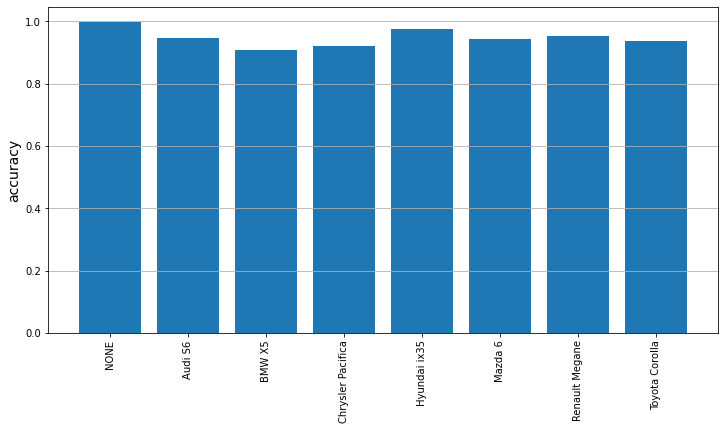

In [14]:
acc = check_accuracy(test_loader, model)

plt.figure(figsize=(12, 6))
plt.bar(acc.keys(), acc.values())
plt.xticks(rotation=90)
plt.ylabel('accuracy', fontsize=14)
plt.grid(axis='y')
plt.show()

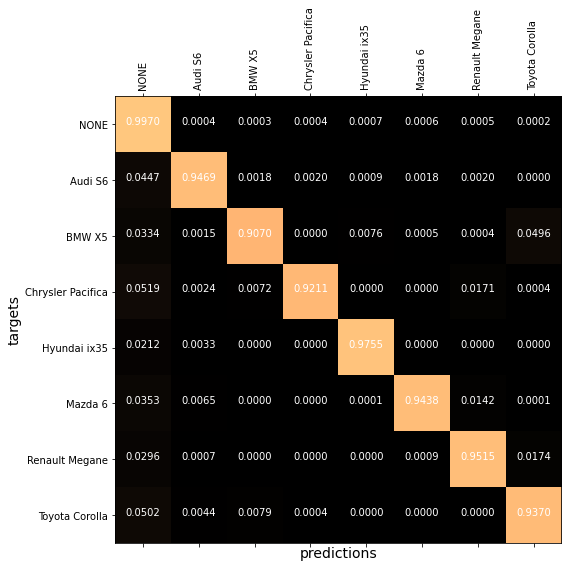

In [15]:
cmat = check_confusion_matrix(test_loader, model)

plt.figure(figsize = (8, 8))
plt.matshow(cmat, fignum=1, cmap=plt.cm.copper)

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], CLASSES, rotation='vertical')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], CLASSES, rotation='horizontal')

plt.xlabel('predictions', fontsize=14)
plt.ylabel('targets', fontsize=14)

for i in range(NUM_CLASSES):
  for j in range(NUM_CLASSES):
    plt.text(i, j, f'{cmat[j, i]:0.4f}', color='white', horizontalalignment='center')
plt.show()